In [1]:
import uproot4
import numpy as np
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        })
                       }, depth_limit=1)
    return dq_events


######## READ EVENTS
filename = "ntuples/ApMuons_May262021.root"
dq_events = getData(filename)

Saving plots to:  plot/01-06-2021



## Muons matching

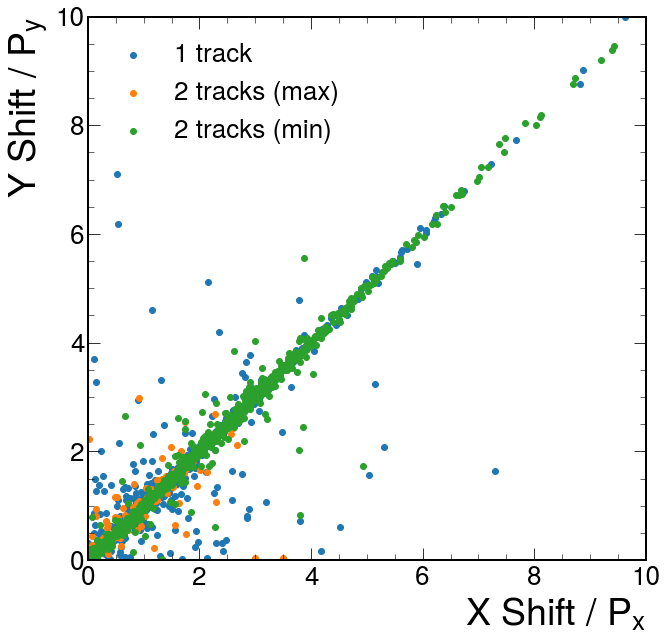

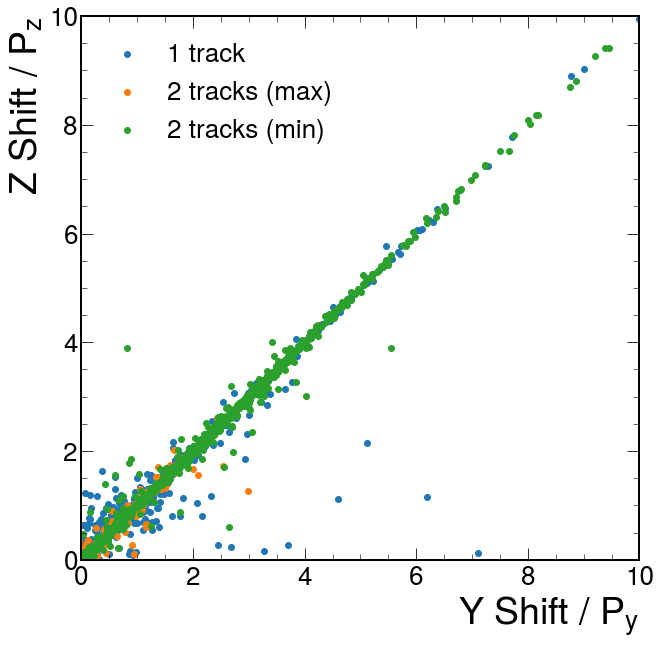

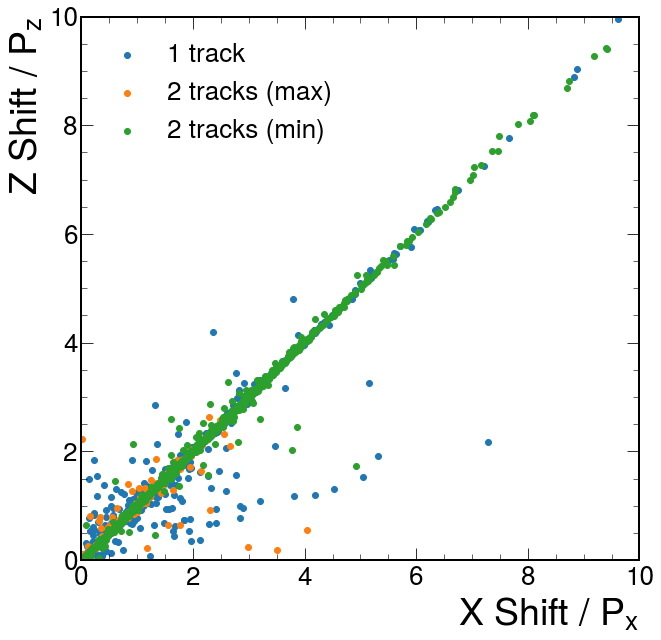

In [2]:
hists = {}

hists["x_ratio_truth"] = hist.Hist("Events",
                             hist.Bin("x_residual", r"$x_{st1~(reco)} - x_{vertex~(truth)}$ [cm]", 40, -10, 10),
                             hist.Bin("px", r"Truth Vertex $p_x$ [GeV]" , 40, 0, 3))
hists["y_ratio_truth"] = hist.Hist("Events",
                             hist.Bin("y_residual", r"$y_{st1~(reco)} - y_{vertex~(truth)}$ [cm]", 40, -10, 10),
                             hist.Bin("py", r"Truth Vertex $p_y$ [GeV]" , 40, 0, 3))
hists["z_ratio_truth"] = hist.Hist("Events",
                             hist.Bin("z_residual", r"$z_{st1~(reco)} - z_{vertex~(truth)}$ [cm]", 40, 0, 150),
                             hist.Bin("pz", r"Truth Vertex $p_z$ [GeV]" , 40, 0, 150))
#RECO
hists["x_ratio_reco"] = hist.Hist("Events",
                             hist.Bin("x_residual", r"$x_{st1~(reco)} - x_{vertex~(truth)}$ [cm]", 40, -10, 10),
                             hist.Bin("px", r"Reco St1 $p_x$ [GeV]" , 40, 0, 3))
hists["y_ratio_reco"] = hist.Hist("Events",
                             hist.Bin("y_residual", r"$y_{st1~(reco)} - y_{vertex~(truth)}$ [cm]", 40, -10, 10),
                             hist.Bin("py", r"Reco St1 $p_y$ [GeV]" , 40, 0, 3))
hists["z_ratio_reco"] = hist.Hist("Events",
                             hist.Bin("z_residual", r"$z_{st1~(reco)} - z_{vertex~(truth)}$ [cm]", 40, 0, 150),
                             hist.Bin("pz", r"Reco St1 $p_z$ [GeV]" , 40, 0, 150))

def processor(dq_events):
    
    GenMuons = dq_events['GenP_St1']
    RecoMuons = dq_events["Track_St1"]
    GenVertices = dq_events['GenVertex']
    nTracks = dq_events['nTrack']
    
    #Dictionary to hold saved arrays
    track_dict = {}
    
    # only look at the events with two tracks reconstructed for now
    # because it is easier to match the pz
    for num_track in [1,2]:
        events_selected = (nTracks.n_tracks == num_track)
        RecoMuons_selected = RecoMuons[events_selected]
        GenMuons_selected = GenMuons[events_selected]
        GenVertices_selected = GenVertices[events_selected]
        
        if num_track == 1:
            #Match based on the closest pz
            match_index = ak.argmin(abs(GenMuons_selected.pz - ak.flatten(RecoMuons_selected.pz)),
                                    axis=1, keepdims=True)
            
            track_dict['reco_x_over_px_1track'] = ak.flatten(RecoMuons_selected.x - GenVertices_selected[match_index].x)/ak.flatten(RecoMuons_selected.px)
            track_dict['reco_y_over_py_1track'] = ak.flatten(RecoMuons_selected.y - GenVertices_selected[match_index].y)/ak.flatten(RecoMuons_selected.py)
            track_dict['reco_z_over_pz_1track'] = ak.flatten(RecoMuons_selected.z - GenVertices_selected[match_index].z)/ak.flatten(RecoMuons_selected.pz)
            
        elif num_track == 2:
            #Max case
            index_reco_pzmax = ak.argmax(RecoMuons_selected.pz, axis=1, keepdims=True)
            index_gen_pzmax = ak.argmax(GenMuons_selected.pz, axis=1, keepdims=True)
            
            track_dict['reco_x_over_px_max2track'] = ak.flatten(RecoMuons_selected[index_reco_pzmax].x - GenVertices_selected[index_gen_pzmax].x)/ak.flatten(RecoMuons_selected[index_reco_pzmax].px)
            track_dict['reco_y_over_py_max2track'] = ak.flatten(RecoMuons_selected[index_reco_pzmax].y - GenVertices_selected[index_gen_pzmax].y)/ak.flatten(RecoMuons_selected[index_reco_pzmax].py)
            track_dict['reco_z_over_pz_max2track'] = ak.flatten(RecoMuons_selected[index_reco_pzmax].z - GenVertices_selected[index_gen_pzmax].z)/ak.flatten(RecoMuons_selected[index_reco_pzmax].pz)
            
            #Min case
            index_reco_pzmin = ak.argmin(RecoMuons_selected.pz, axis=1, keepdims=True)
            index_gen_pzmin = ak.argmin(GenMuons_selected.pz, axis=1, keepdims=True)
            
            track_dict['reco_x_over_px_min2track'] = ak.flatten(RecoMuons_selected[index_reco_pzmin].x - GenVertices_selected[index_gen_pzmin].x)/ak.flatten(RecoMuons_selected[index_reco_pzmin].px)
            track_dict['reco_y_over_py_min2track'] = ak.flatten(RecoMuons_selected[index_reco_pzmin].y - GenVertices_selected[index_gen_pzmin].y)/ak.flatten(RecoMuons_selected[index_reco_pzmin].py)
            track_dict['reco_z_over_pz_min2track'] = ak.flatten(RecoMuons_selected[index_reco_pzmin].z - GenVertices_selected[index_gen_pzmin].z)/ak.flatten(RecoMuons_selected[index_reco_pzmin].pz)
    
    # Label map
    label_map = {'1track': '1 track', 'max2track': '2 tracks (max)', 'min2track': '2 tracks (min)'}
    
    #Plot the results
    for var in ['1track', 'max2track', 'min2track']:
        
        #X
        plt.scatter(track_dict['reco_x_over_px_{}'.format(var)], track_dict['reco_y_over_py_{}'.format(var)],
                   label = label_map[var])
    
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.xlabel(r'X Shift / $P_x$')
    plt.ylabel(r'Y Shift / $P_y$')
    plt.legend(loc ='best')
    plt.show()
    
    #Second plot
    for var in ['1track', 'max2track', 'min2track']:
        
        #X
        plt.scatter(track_dict['reco_y_over_py_{}'.format(var)], track_dict['reco_z_over_pz_{}'.format(var)],
                   label = label_map[var])
    
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.xlabel(r'Y Shift / $P_y$')
    plt.ylabel(r'Z Shift / $P_z$')
    plt.legend(loc ='best')
    plt.show()
    
    #Third plot
    for var in ['1track', 'max2track', 'min2track']:
        
        #X
        plt.scatter(track_dict['reco_x_over_px_{}'.format(var)], track_dict['reco_z_over_pz_{}'.format(var)],
                   label = label_map[var])
    
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.xlabel(r'X Shift / $P_x$')
    plt.ylabel(r'Z Shift / $P_z$')
    plt.legend(loc ='best')
    plt.show()
    
    """
    # take the max so that no need to do matching
    # not always correct, but should work at leading order
    index_reco_pzmax = ak.argmin(RecoMuons_selected.pz, axis=1, keepdims=True)
    index_gen_pzmax = ak.argmin(GenMuons_selected.pz, axis=1, keepdims=True)
    
    reco_x_over_px = ak.flatten(RecoMuons_selected[index_reco_pzmax].x - GenVertices_selected[index_gen_pzmax].vx)/ak.flatten(RecoMuons_selected[index_reco_pzmax].px)
    reco_y_over_py = ak.flatten(RecoMuons_selected[index_reco_pzmax].y - GenVertices_selected[index_gen_pzmax].vy)/ak.flatten(RecoMuons_selected[index_reco_pzmax].py)
    reco_z_over_pz = ak.flatten(RecoMuons_selected[index_reco_pzmax].z - GenVertices_selected[index_gen_pzmax].vz)/ak.flatten(RecoMuons_selected[index_reco_pzmax].pz)
    
    print(RecoMuons_selected[index_reco_pzmax].x)
    
    fig = plt.figure(figsize=(10,8))
    plt.scatter(reco_x_over_px, reco_y_over_py)
    plt.xlim(0,5)
    plt.ylim(0,5)
    plt.xlabel("X Shift / Px")
    plt.ylabel('Y Shift / Py')
    #plt.savefig("plots/move_xy_reco.png")

    fig = plt.figure(figsize=(10,8))
    plt.scatter(reco_x_over_px, reco_z_over_pz)
    plt.xlim(0,5)
    plt.ylim(0,5)
    plt.xlabel("X Shift / Px")
    plt.ylabel('Z Shift / PZ')
    #plt.savefig("plots/move_xz_reco.png")

    fig = plt.figure(figsize=(10,8))
    plt.scatter(reco_y_over_py, reco_z_over_pz)
    plt.xlim(0,5)
    plt.ylim(0,5)
    plt.xlabel("Y Shift / Px")
    plt.ylabel('Z Shift / PZ')
    #plt.savefig("plots/move_yz_reco.png")
    """

processor(dq_events)

In [7]:
0.103 - 0.106

-0.0030000000000000027